In [1]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import pyro.poutine as poutine

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from tyxe_runfiles import generate
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
import tyxe.util as util

import pickle

In [2]:
BASE_DIR = "./tests/underspecified"
PROFILE = "model"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile linear-1d-1k ======
Train: (-2, 2)
Y-space: -2.3190887183118765 - 4.615517700952764
In Domain: (-2, 2)
Y-space: -2.456861633662428 - 4.3960773498089445
Out Domain: (-4, 4)
Y-space: -3.611024641978509 - 5.890028628058182


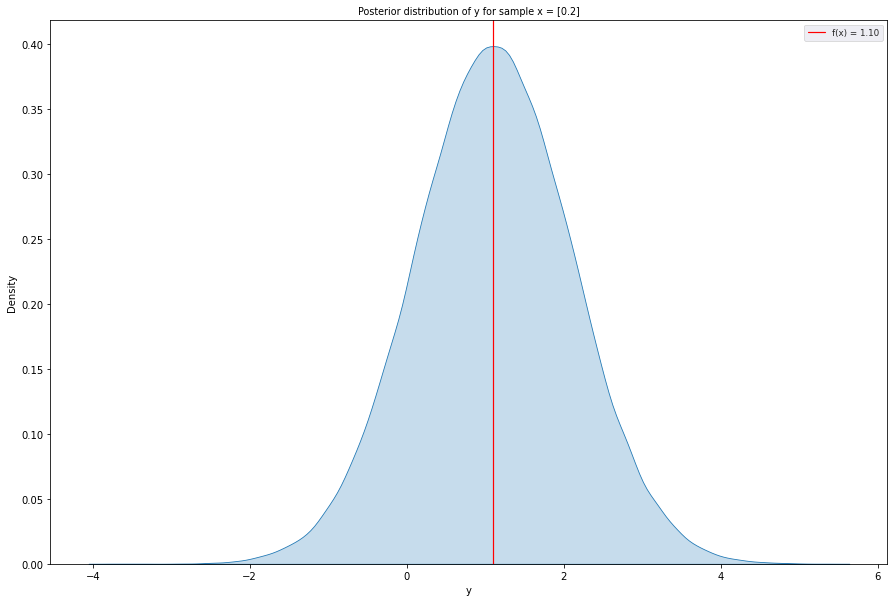

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


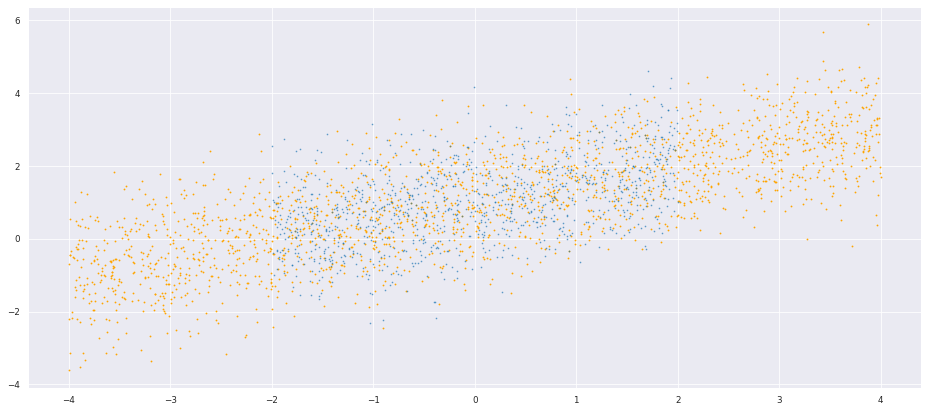

In [7]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test.squeeze(), y_test, color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1, alpha=0.5)


In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=512)

In [9]:
"""SVI"""

'SVI'

In [10]:
#net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1))
net = nn.Linear(1, 1)
prior = tyxe.priors.IIDPrior(dist.Normal(1, 1))

obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=0.01)
likelihood_guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
#likelihood_guide_builder = None

guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.bnn.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

In [11]:
with pyro.poutine.trace() as tr:
    bnn.guide(x_test)
    print(tr.trace.nodes.keys())
    print(tr.trace.nodes["likelihood._scale"]["value"])
    print(tr.trace.nodes["likelihood_guide.likelihood._scale.loc"]["value"])
    print(tr.trace.nodes["likelihood_guide.likelihood._scale.scale"]["value"])

odict_keys(['net_guide.net.weight.loc', 'net_guide.net.weight.scale', 'net_guide.net.bias.loc', 'net_guide.net.bias.scale', 'net.weight', 'net.bias', 'likelihood_guide.likelihood._scale.loc', 'likelihood_guide.likelihood._scale.scale', 'likelihood._scale'])
tensor(0.6541, grad_fn=<AddBackward0>)
Parameter containing:
tensor(-0.4193, requires_grad=True)
tensor(0.0100, grad_fn=<AddBackward0>)


In [12]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-4})
elbos = []
def callback(bnn, i, e):
    if i % 100 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dataloader, optim, 20000, callback)

In [13]:
if True:
    with poutine.trace() as tr:
        bnn.guide(x_train, y_train)
        print(tr.trace.nodes.keys())
        print(tr.trace.nodes["likelihood_guide.likelihood._scale.loc"]["value"], tr.trace.nodes["likelihood_guide.likelihood._scale.scale"]["value"])
        print(tr.trace.nodes["likelihood._scale"]["value"])

odict_keys(['net_guide.net.weight.loc', 'net_guide.net.weight.scale', 'net.weight', 'net_guide.net.bias.loc', 'net_guide.net.bias.scale', 'net.bias', 'likelihood_guide.likelihood._scale.loc', 'likelihood_guide.likelihood._scale.scale', 'likelihood._scale'])
Parameter containing:
tensor(-0.4193, requires_grad=True) tensor(0.0100, grad_fn=<AddBackward0>)
tensor(0.6625, grad_fn=<AddBackward0>)


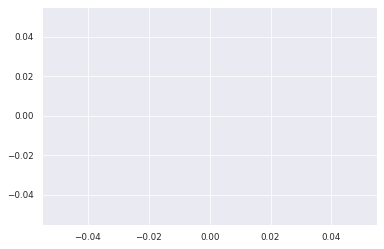

In [14]:
plt.plot(elbos)

In [15]:
with poutine.trace() as tr:
    bnn.likelihood(x_test[:2], aggregate_mode=True)
    print(tr.trace.nodes.keys())

odict_keys(['likelihood._scale'])


In [16]:
pr = bnn.predict(x_test[:3], num_predictions=10, aggregate=False)

In [17]:
pr.shape

torch.Size([10, 3, 1])

In [18]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)
print(preds[0].shape, preds[1].shape)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

torch.Size([2000, 1]) torch.Size([2000, 1])


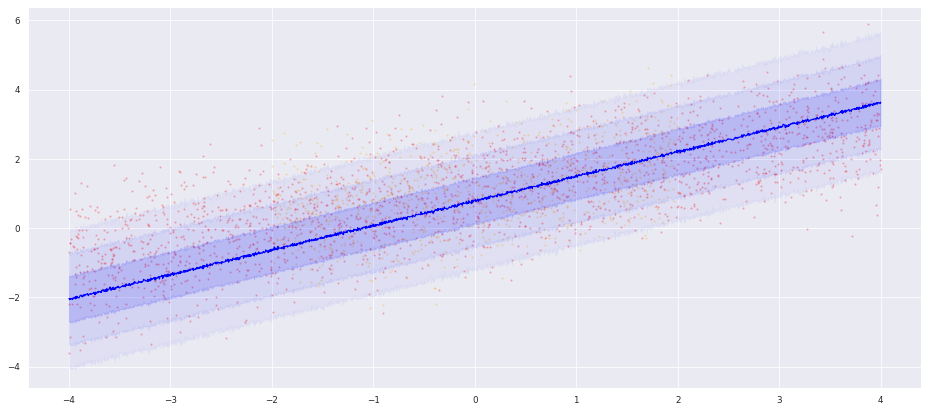

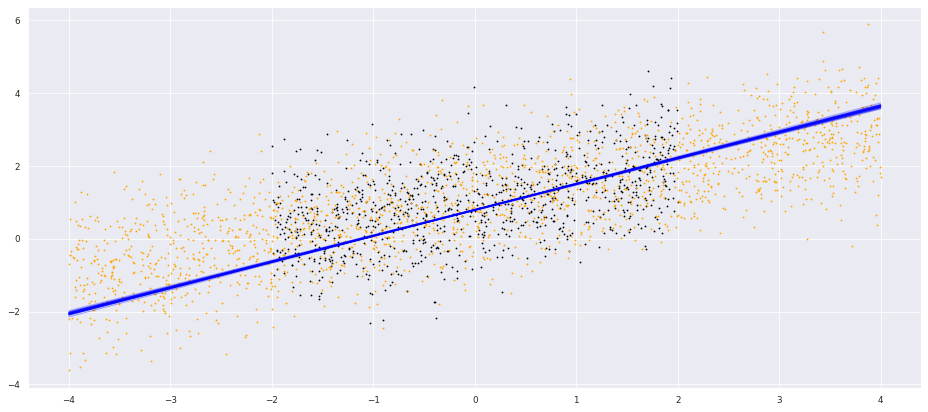

In [19]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [20]:
predictive = pyro.infer.Predictive(bnn.model, guide=bnn.guide, num_samples=1000)
pred = predictive(x_test[1:5])

In [21]:
print(pred.keys())
print(pred["likelihood.data"].shape)
print(pred["likelihood.data"][0])

dict_keys(['net.weight', 'net.bias', 'likelihood._scale', 'likelihood.data'])
torch.Size([1000, 4, 1])
tensor([[-0.3482],
        [ 0.1505],
        [-0.6395],
        [-0.7261]])


In [22]:
raise Exception("stop")

Exception: stop

In [ ]:
"""MCMC"""

'MCMC'

In [ ]:
net = nn.Linear(1, 1)
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(0.1), constraint=dist.constraints.positive))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=0.1)

kernel = pyro.infer.mcmc.NUTS

bnn = tyxe.MCMC_BNN(net, prior, obs_model, kernel)

In [ ]:
pyro.clear_param_store()

bnn.fit(train_dataloader, num_samples=1000, warmup_steps=1000)

Sample: 100%|██████████| 2000/2000 [00:24, 80.24it/s, step size=3.13e-01, acc. prob=0.938] 


In [ ]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

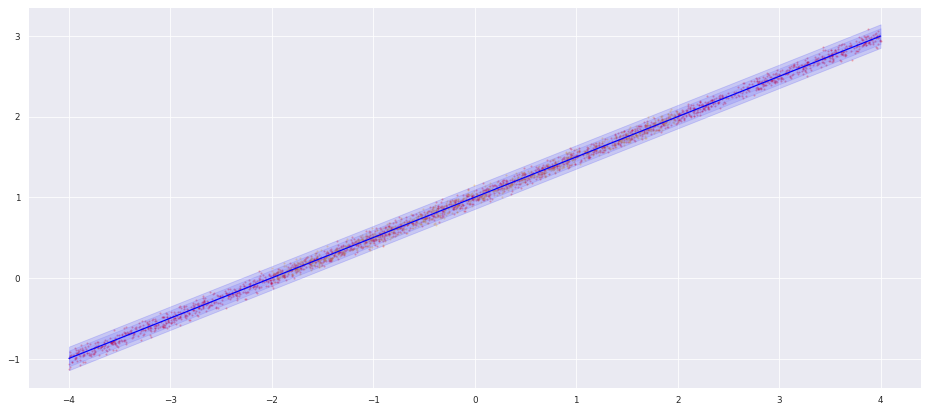

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=c/2 * 0.1, color="blue")

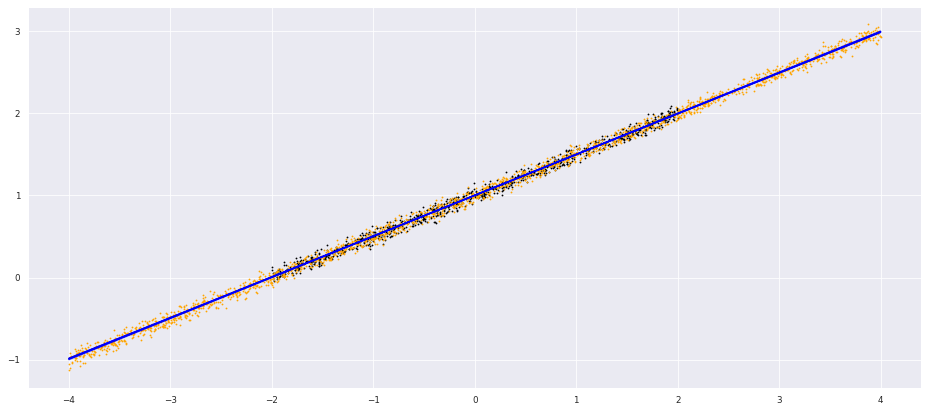

In [ ]:
sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [ ]:
weight_samples = bnn._mcmc.get_samples(num_samples=10)


In [ ]:
print(x_test[:2])
with poutine.trace() as tr:
    #r = bnn.likelihood(x_test[:2], test=True)
    r = poutine.condition(bnn.likelihood, {"likelihood._scale": 0.1})(x_test[:2], aggregate_mode=True)
r

tensor([[-0.7823],
        [-0.5781]])


(tensor([-0.6802]), tensor([0.1756]))

In [ ]:
tr.trace.nodes.keys()
tr.trace.nodes["likelihood._scale"]["value"]

0.1

In [ ]:
tr = poutine.trace(bnn.likelihood).get_trace(x_test[:2])
print(tr.nodes.keys())
print(tr.nodes["likelihood._scale"])

odict_keys(['_INPUT', 'likelihood._scale', 'likelihood.data_plate', 'likelihood.data', '_RETURN'])
{'type': 'sample', 'name': 'likelihood._scale', 'fn': Gamma(concentration: 1.0, rate: 1.0), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor(0.2729), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None}
